# HMS - HARMFUL BRAIN ACTIVITY CLASSIFICATION

In [1]:
import os
import pandas as pd, numpy as np
from glob import glob
import matplotlib.pyplot as plt
VER = 1

In [2]:
BASE_PATH = '/kaggle/input/hms-harmful-brain-activity-classification/'
file_paths = glob(os.path.join(BASE_PATH, '**', '*.parquet'), recursive=True)
df = pd.DataFrame({'path': file_paths})
df['test_type'] = df['path'].apply(
    lambda p: os.path.basename(os.path.dirname(p)).split('_')[-1]
)
df['id'] = df['path'].apply(
    lambda p: os.path.splitext(os.path.basename(p))[0]
)
df_eeg = pd.read_parquet(
    os.path.join(BASE_PATH, 'train_eegs', '1000913311.parquet')
)
df_eeg.head()

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-105.849998,-89.230003,-79.459999,-49.230000,-99.730003,-87.769997,-53.330002,-50.740002,-32.250000,-42.099998,-43.270000,-88.730003,-74.410004,-92.459999,-58.930000,-75.739998,-59.470001,8.210000,66.489998,1404.930054
1,-85.470001,-75.070000,-60.259998,-38.919998,-73.080002,-87.510002,-39.680000,-35.630001,-76.839996,-62.740002,-43.040001,-68.629997,-61.689999,-69.320000,-35.790001,-58.900002,-41.660000,196.190002,230.669998,3402.669922
2,8.840000,34.849998,56.430000,67.970001,48.099998,25.350000,80.250000,48.060001,6.720000,37.880001,61.000000,16.580000,55.060001,45.020000,70.529999,47.820000,72.029999,-67.180000,-171.309998,-3565.800049
3,-56.320000,-37.279999,-28.100000,-2.820000,-43.430000,-35.049999,3.910000,-12.660000,8.650000,3.830000,4.180000,-51.900002,-21.889999,-41.330002,-11.580000,-27.040001,-11.730000,-91.000000,-81.190002,-1280.930054
4,-110.139999,-104.519997,-96.879997,-70.250000,-111.660004,-114.430000,-71.830002,-61.919998,-76.150002,-79.779999,-67.480003,-99.029999,-93.610001,-104.410004,-70.070000,-89.250000,-77.260002,155.729996,264.850006,4325.370117


In [3]:
n_channels = len(df_eeg.columns)
n_channels

20

In [4]:
csv_path = '/kaggle/input/hms-harmful-brain-activity-classification/train.csv'
df = pd.read_csv(csv_path)
TARGETS = df.columns[-6:]
num_rows, num_cols = df.shape
print(f"Train.csv contains {num_rows} records across {num_cols} columns.")
print(f"Target columns: {TARGETS.tolist()}")
df.head()

Train.csv contains 106800 records across 15 columns.
Target columns: ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [5]:
segment_bounds = df.groupby('eeg_id')[['spectrogram_id', 'spectrogram_label_offset_seconds']].agg({
    'spectrogram_id': 'first',
    'spectrogram_label_offset_seconds': 'min'
})
segment_bounds.columns = ['spec_id', 'min']
end_times = df.groupby('eeg_id')[['spectrogram_label_offset_seconds']].agg('max')
segment_bounds['max'] = end_times

patient_info = df.groupby('eeg_id')[['patient_id']].agg('first')
segment_bounds['patient_id'] = patient_info

target_counts = df.groupby('eeg_id')[TARGETS].agg('sum')
for label in TARGETS:
    segment_bounds[label] = target_counts[label].values

label_matrix = segment_bounds[TARGETS].values
label_matrix = label_matrix / label_matrix.sum(axis=1, keepdims=True)
segment_bounds[TARGETS] = label_matrix

expert_labels = df.groupby('eeg_id')[['expert_consensus']].agg('first')
segment_bounds['target'] = expert_labels

train = segment_bounds.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape)
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [6]:
READ_SPEC_FILES = False 
FEATURE_ENGINEER = True

In [7]:
%%time
SPECTROGRAM_DIR = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'
file_list = os.listdir(SPECTROGRAM_DIR)
print(f'There are {len(file_list)} spectrogram parquets')

if READ_SPEC_FILES:
    spectrograms = {}
    for idx, file_name in enumerate(file_list):
        if idx % 100 == 0:
            print(idx, ', ', end='')
        spec_df = pd.read_parquet(f'{SPECTROGRAM_DIR}{file_name}')
        spec_id = int(file_name.split('.')[0])
        spectrograms[spec_id] = spec_df.iloc[:, 1:].values
else:
    spectrograms = np.load('/kaggle/input/brain-spectrograms/specs.npy', allow_pickle=True).item()

There are 11138 spectrogram parquets
CPU times: user 4.84 s, sys: 11.2 s, total: 16.1 s
Wall time: 47 s


In [8]:
%time
import warnings
warnings.filterwarnings('ignore')
SPEC_COLS = pd.read_parquet(f'{SPECTROGRAM_DIR }1000086677.parquet').columns[1:]

FEATURES = [f'{col}_mean_15m' for col in SPEC_COLS]
FEATURES += [f'{col}_min_15m' for col in SPEC_COLS]
FEATURES += [f'{col}_mean_50s' for col in SPEC_COLS]
FEATURES += [f'{col}_min_50s' for col in SPEC_COLS]

print(f'We are creating {len(FEATURES)} features for {len(train)} rows... ', end='')

if FEATURE_ENGINEER:
    feature_matrix = np.zeros((len(train), len(FEATURES)))
    
    for idx in range(len(train)):
        if idx % 100 == 0:
            print(idx, ', ', end='')
        row_data = train.iloc[idx]
        center_index = int((row_data['min'] + row_data['max']) // 4)

        segment = spectrograms[row_data.spec_id][center_index:center_index + 450, :]
        feature_vals = np.nanmean(segment, axis=0)
        feature_matrix[idx, :400] = feature_vals
        feature_vals = np.nanmin(segment, axis=0)
        feature_matrix[idx, 400:800] = feature_vals
        
        short_segment = spectrograms[row_data.spec_id][center_index + 145:center_index + 170, :]
        feature_vals = np.nanmean(short_segment, axis=0)
        feature_matrix[idx, 800:1200] = feature_vals
        feature_vals = np.nanmin(short_segment, axis=0)
        feature_matrix[idx, 1200:1600] = feature_vals
        
    train[FEATURES] = feature_matrix
else:
    train = pd.read_parquet('/kaggle/input/brain-spectrograms/train.pqt')

print()
print('New train shape:', train.shape)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.39 µs
We are creating 1600 features for 17089 rows... 0 , 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 11200 , 11300 , 11400 , 11500 , 11600 , 11700 , 11800 , 11900 , 12000 , 12100 , 12200 , 12300 , 12400 , 

In [9]:
from scipy import signal
from sklearn.decomposition import PCA

In [10]:
def extract_frequency_band_features(segment):
    eeg_bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 45)
    }
    band_features = []
    for band in eeg_bands:
        low, high = eeg_bands[band]
        bandpass_sos = signal.butter(3, [low, high], btype='bandpass', fs=200, output='sos')
        filtered_signal = signal.sosfilt(bandpass_sos, segment)
        band_features.extend([
            np.nanmean(filtered_signal),  
            np.nanstd(filtered_signal),    
            np.nanmax(filtered_signal),    
            np.nanmin(filtered_signal)     
        ])
    return band_features

In [11]:
train.head()

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,...,RP_18.16_min_50s,RP_18.36_min_50s,RP_18.55_min_50s,RP_18.75_min_50s,RP_18.95_min_50s,RP_19.14_min_50s,RP_19.34_min_50s,RP_19.53_min_50s,RP_19.73_min_50s,RP_19.92_min_50s
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,...,0.20,0.19,0.17,0.16,0.19,0.21,0.17,0.19,0.15,0.13
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,...,0.02,0.02,0.02,0.01,0.02,0.02,0.02,0.02,0.02,0.02
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,...,0.05,0.04,0.05,0.04,0.03,0.05,0.03,0.05,0.04,0.04
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,...,0.06,0.05,0.05,0.06,0.06,0.06,0.06,0.04,0.05,0.03
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,...,0.09,0.13,0.13,0.12,0.08,0.06,0.06,0.09,0.09,0.04


In [12]:
import gc
import xgboost as xgb
from sklearn.model_selection import KFold, GroupKFold
print('XGBoost version', xgb.__version__)

XGBoost version 2.0.3


#########################
### Fold 1
### train size 13671, valid size 3418
#########################
#########################
### Fold 2
### train size 13671, valid size 3418
#########################
#########################
### Fold 3
### train size 13671, valid size 3418
#########################
#########################
### Fold 4
### train size 13671, valid size 3418
#########################
#########################
### Fold 5
### train size 13672, valid size 3417
#########################


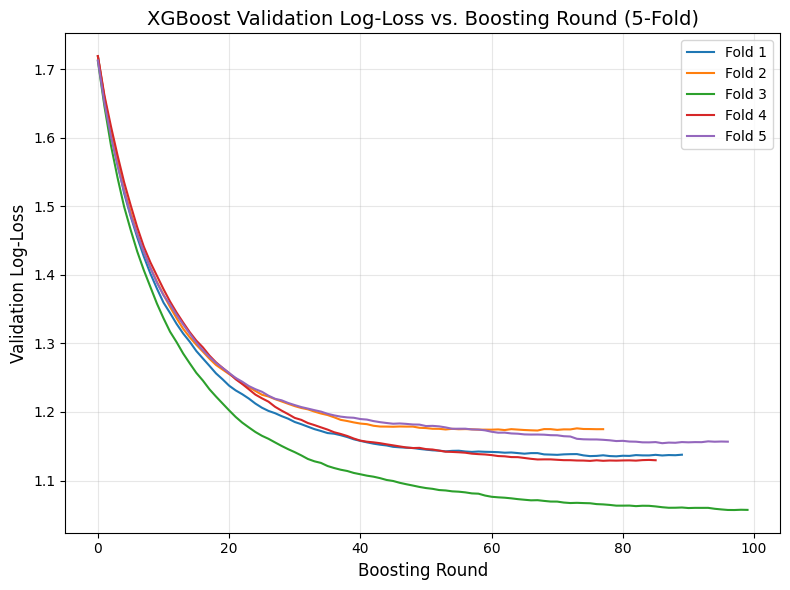

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
import xgboost as xgb
import gc

all_oof   = []
all_true  = []
all_evals = []    

TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
gkf  = GroupKFold(n_splits=5)

for i, (train_index, valid_index) in enumerate(
        gkf.split(train, train.target, train.patient_id)
    ):
    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)

    model = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=len(TARS),
        learning_rate=0.1,
        tree_method='hist', 
        eval_metric='mlogloss'
    )
    X_train = train.loc[train_index, FEATURES]
    y_train = train.loc[train_index, 'target'].map(TARS)
    X_valid = train.loc[valid_index, FEATURES]
    y_valid = train.loc[valid_index, 'target'].map(TARS)

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False,
        early_stopping_rounds=10
    )
    
    evals_result = model.evals_result()
    val_logloss = evals_result['validation_0']['mlogloss']
    all_evals.append(val_logloss)
   
    oof = model.predict_proba(X_valid)
    all_oof.append(oof)
    all_true.append(train.loc[valid_index, TARGETS].values)

    model.save_model(f'XGB_v{VER}_f{i}.model')

    del X_train, y_train, X_valid, y_valid, oof
    gc.collect()

all_oof  = np.concatenate(all_oof, axis=0)
all_true = np.concatenate(all_true, axis=0)

plt.figure(figsize=(8, 6))
for fold_idx, logloss_curve in enumerate(all_evals):
    plt.plot(
        logloss_curve,
        label=f'Fold {fold_idx+1}',
        linewidth=1.5
    )
    
plt.xlabel('Boosting Round', fontsize=12)
plt.ylabel('Validation Log‐Loss', fontsize=12)
plt.title('XGBoost Validation Log‐Loss vs. Boosting Round (5‐Fold)', fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

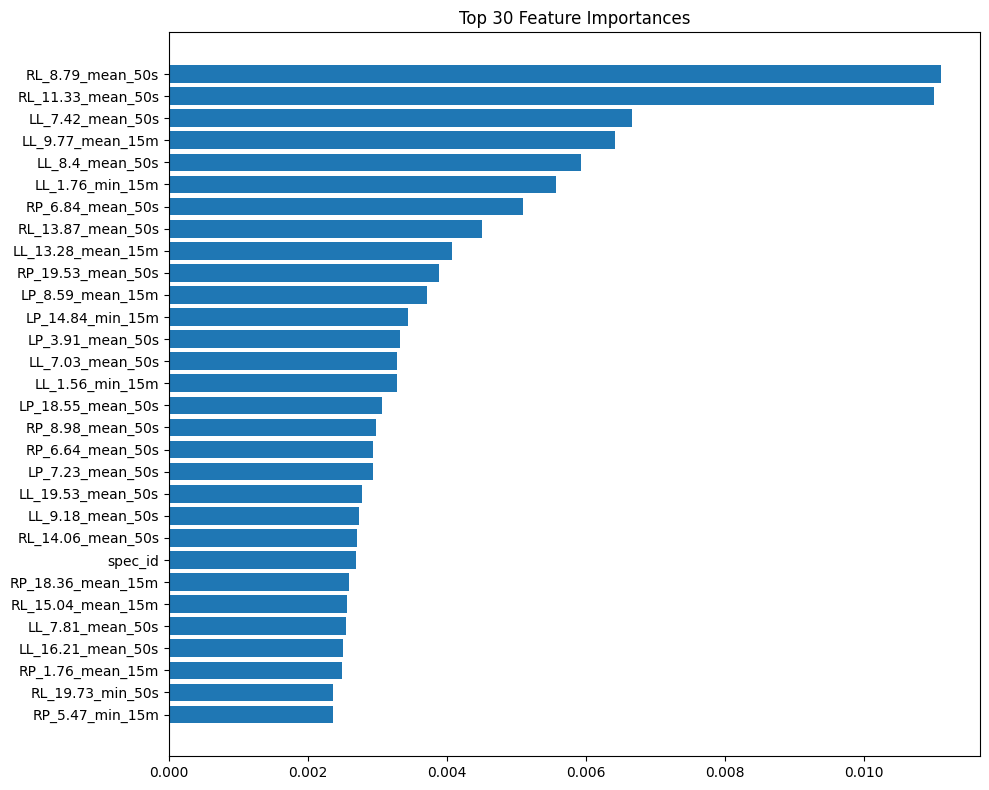

In [14]:
TOP_K = 30
importances = model.feature_importances_
all_features = train.columns
ranking_indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
top_indices = ranking_indices[-TOP_K:]
plt.barh(np.arange(TOP_K), importances[top_indices], align='center')
plt.yticks(np.arange(TOP_K), all_features[top_indices])
plt.title(f'Top {TOP_K} Feature Importances')
plt.tight_layout()
plt.show()

In [15]:
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape',test.shape)
test.head()

Test shape (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [16]:
s = 853520
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
spec = pd.read_parquet(f'{PATH2}{s}.parquet')
spec

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,14.910000,17.110001,11.660000,11.73,6.08,4.54,4.31,3.38,2.05,...,0.07,0.06,0.05,0.06,0.05,0.05,0.06,0.05,0.04,0.05
1,3,11.130000,10.950000,10.770000,5.07,4.03,3.24,3.61,2.98,1.54,...,0.05,0.04,0.04,0.04,0.04,0.04,0.03,0.03,0.03,0.02
2,5,10.880000,10.570000,8.790000,5.33,2.44,1.48,1.83,0.99,0.89,...,0.04,0.04,0.04,0.03,0.03,0.04,0.04,0.05,0.06,0.06
3,7,19.450001,18.200001,17.719999,13.38,4.17,1.88,1.84,1.22,1.27,...,0.03,0.03,0.05,0.08,0.07,0.07,0.08,0.03,0.03,0.03
4,9,21.650000,22.530001,23.160000,17.00,7.19,3.89,3.65,2.72,2.35,...,0.04,0.04,0.05,0.05,0.06,0.05,0.05,0.05,0.04,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,591,15.580000,18.209999,14.020000,15.96,4.36,4.98,2.68,2.22,2.03,...,0.48,0.59,0.59,0.73,0.44,0.41,0.56,0.60,0.61,0.60
296,593,17.209999,20.219999,20.889999,17.16,9.15,4.14,2.49,2.71,1.60,...,0.26,0.37,0.41,0.36,0.48,0.36,0.39,0.46,0.34,0.32
297,595,9.610000,13.320000,9.190000,11.50,8.11,5.53,5.57,3.69,3.19,...,0.58,0.37,0.17,0.14,0.13,0.30,0.36,0.39,0.56,0.29
298,597,8.430000,11.840000,13.640000,10.56,8.63,5.80,2.98,1.48,0.96,...,0.54,0.22,0.17,0.16,0.11,0.38,0.45,0.45,0.45,0.34


In [17]:
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_spectrograms/'
data = np.zeros((len(test),len(FEATURES))) 
for k in range(len(test)):
    row = test.iloc[k]
    s = int( row.spectrogram_id )
    spec = pd.read_parquet(f'{PATH2}{s}.parquet')
    x = np.nanmean( spec.iloc[:,1:].values, axis=0)
    data[k,:400] = x
    x = np.nanmin( spec.iloc[:,1:].values, axis=0)
    data[k,400:800] = x
    x = np.nanmean( spec.iloc[145:155,1:].values, axis=0)
    data[k,800:1200] = x
    x = np.nanmin( spec.iloc[145:155,1:].values, axis=0)
    data[k,1200:1600] = x

test[FEATURES] = data
print('New test shape',test.shape)
print(test)

New test shape (1, 1603)
   spectrogram_id      eeg_id  patient_id  LL_0.59_mean_15m  LL_0.78_mean_15m  \
0          853520  3911565283        6885         16.864132         19.120567   

   LL_0.98_mean_15m  LL_1.17_mean_15m  LL_1.37_mean_15m  LL_1.56_mean_15m  \
0         18.342468         13.408634            8.0575          4.890133   

   LL_1.76_mean_15m  ...  RP_18.16_min_50s  RP_18.36_min_50s  \
0          3.460633  ...              0.04              0.04   

   RP_18.55_min_50s  RP_18.75_min_50s  RP_18.95_min_50s  RP_19.14_min_50s  \
0              0.05              0.04              0.04              0.04   

   RP_19.34_min_50s  RP_19.53_min_50s  RP_19.73_min_50s  RP_19.92_min_50s  
0              0.04              0.02              0.03              0.03  

[1 rows x 1603 columns]


In [18]:
preds = []
for i in range(5):
    print(i, ', ', end='')
    model = xgb.XGBClassifier()
    model.load_model(f'XGB_v{VER}_f{i}.model')
    pred = model.predict_proba(test[FEATURES])
    preds.append(pred)

pred = np.mean(preds, axis=0)
print()
print('Test preds shape', pred.shape)
print(pred)

0 , 1 , 2 , 3 , 4 , 
Test preds shape (1, 6)
[[0.10100694 0.05309061 0.00624592 0.2503283  0.04314722 0.54618096]]


In [19]:
sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submission shape',sub.shape)
sub.head()
print(sub)

Submission shape (1, 7)
       eeg_id  seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  \
0  3911565283      0.101007  0.053091  0.006246   0.250328   0.043147   

   other_vote  
0    0.546181  


In [20]:
sub.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float32